In [1]:
# Link: https://www.kaggle.com/amateurdesperado/pca-var-cv-simple-nn

In [2]:
import sys
import numpy as np
import random
import pandas as pd
import os
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_style('ticks')
sns.set_context("poster")
sns.set_palette('colorblind')
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
params = {'device': device,
          'n_comp_g': 450, 
          'n_comp_c': 45, 
          'var_thresh': 0.67,
          'epochs': 25,
          'batch_size': 128,
          'lr': 1e-3,
          'weight_decay': 1e-5, 
          'n_folds': 7, 
          'early_stopping_steps': 10,
          'early_stop': False,
          'in_size': None,
          'out_size': None,
          'hidden_size': 1500}

In [7]:
train_features = pd.read_csv('../data/train_features.csv') # ../input/lish-moa/
train_targets = pd.read_csv('../data/train_targets_scored.csv') # ../input/lish-moa/

test_features = pd.read_csv('../data/test_features.csv') # ../input/lish-moa/
sample_submission = pd.read_csv('../data/sample_submission.csv') # ../input/lish-moa/

In [8]:
train_features.shape

(23814, 876)

In [9]:
test_features.shape

(3982, 876)

In [10]:
sample_submission.shape

(3982, 207)

In [11]:
g_features = [col for col in train_features.columns if col.startswith('g-')]
c_features = [col for col in train_features.columns if col.startswith('c-')]

g_c_features = g_features + c_features

In [12]:
transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")

In [13]:
trans_train_features = transformer.fit_transform(train_features[g_c_features])
trans_test_features = transformer.transform(test_features[g_c_features])

trans_train_df = pd.DataFrame(trans_train_features, columns = g_c_features)
trans_test_df = pd.DataFrame(trans_test_features, columns = g_c_features)

train_features = pd.concat([train_features.drop(columns=g_c_features), trans_train_df], axis=1)
test_features = pd.concat([test_features.drop(columns=g_c_features), trans_test_df], axis=1)

In [14]:
g_sample = random.sample(g_features, 3)
c_sample = random.sample(c_features, 3)

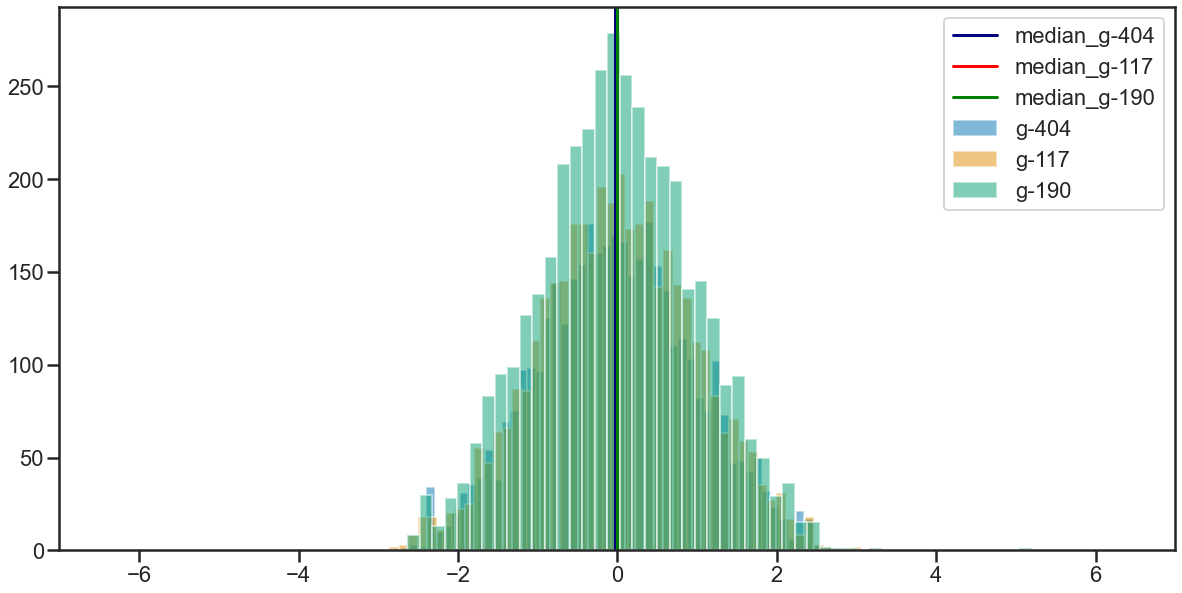

In [15]:
colors = ['navy', 'r', 'g']
for col, color in zip(g_sample, colors):
    plt.hist(test_features[col], bins=50, alpha=0.5, label=col)
    plt.axvline(np.median(test_features[col]), linewidth=3, color=color, label='median_{}'.format(col))
plt.xlim(-7, 7)
plt.legend();

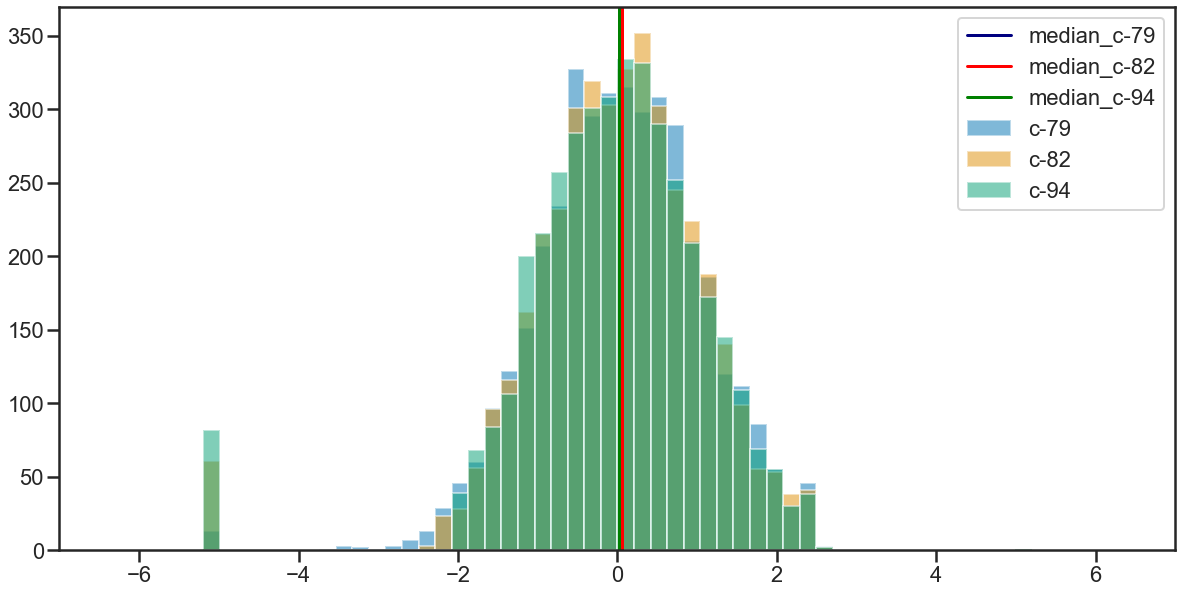

In [16]:
colors = ['navy', 'r', 'g']
for col, color in zip(c_sample, colors):
    plt.hist(test_features[col], bins=50, alpha=0.5, label=col)
    plt.axvline(np.median(test_features[col]), linewidth=3, color=color, label='median_{}'.format(col))
plt.xlim(-7, 7)
plt.legend();

In [17]:
def transfrom_all_data(transformer, train, test, feature_list):
    
    data = pd.concat([train[feature_list], test[feature_list]], axis=0).reset_index(drop=True)
    n = train.shape[0]
    
    data_trans = transformer.fit_transform(data)
    train_trans = data_trans[:n, :]
    test_trans = data_trans[n:, :]
    return train_trans, test_trans

In [18]:
def make_pca_features(n_comp, train, test, feature_list, name, normalize=False, scaler=None):
    
    pca = PCA(n_comp)
    
    train_pca, test_pca = transfrom_all_data(pca, train, test, feature_list)
    
    if normalize and scaler is not None:
        train_pca = scaler.fit_transform(train_pca)
        test_pca = scaler.transform(test_pca)
    
    for i in range(n_comp):
        train['{0}_{1}'.format(name, i)] = train_pca[:, i]
        test['{0}_{1}'.format(name, i)] = test_pca[:, i]
        
    return train, test

In [19]:
def preprocess(data):
    data['cp_time'] = data['cp_time'].map({24:0, 48:1, 72:2})
    data['cp_dose'] = data['cp_dose'].map({'D1':0, 'D2':1})
    return data

In [20]:
train_features, test_features = make_pca_features(params['n_comp_g'], train_features, test_features, g_features, 'g_pca')

In [21]:
train_features, test_features = make_pca_features(params['n_comp_c'], train_features, test_features, c_features, 'c_pca')

In [22]:
var_thresh = VarianceThreshold(params['var_thresh'])
to_thresh = train_features.columns[4:]
cat_features = train_features.columns[:4]

In [23]:
train_thresh, test_thresh = transfrom_all_data(var_thresh, train_features, test_features, to_thresh)

In [24]:
train_features = pd.concat([train_features[cat_features], pd.DataFrame(train_thresh)], axis=1)
test_features = pd.concat([test_features[cat_features], pd.DataFrame(test_thresh)], axis=1)

In [26]:
train_features.shape

(23814, 1092)

In [27]:
test_features.shape

(3982, 1092)

In [28]:
train_mask = train_features['cp_type'] != 'ctl_vehicle'
train_sig_ids = train_features.loc[train_mask]['sig_id']
train = train_features.loc[train_mask].reset_index(drop=True)

test_mask = test_features['cp_type'] != 'ctl_vehicle'
test_sig_ids = test_features.loc[test_mask]['sig_id']
test = test_features.loc[test_mask].reset_index(drop=True)

train_target_sigids = train_targets[['sig_id']]
y_true  = train_targets.copy()

train_targets = train_targets[train_targets['sig_id'].isin(train_sig_ids)].reset_index(drop=True)
train_targets.drop(columns=['sig_id'], inplace=True)
train_targets.reset_index(drop=True, inplace=True)

In [29]:
train.shape

(21948, 1092)

In [30]:
test.shape

(3624, 1092)

In [31]:
y_true.shape

(23814, 207)

In [32]:
train_targets.shape

(21948, 206)

In [33]:
train_target_sigids

,sig_id
0,id_000644bb2
1,id_000779bfc
2,id_000a6266a
3,id_0015fd391
4,id_001626bd3
...,...
23809,id_fffb1ceed
23810,id_fffb70c0c
23811,id_fffc1c3f4
23812,id_fffcb9e7c


In [34]:
params['in_size'] = train.shape[1] - 2
params['out_size'] = train_targets.shape[1]

In [35]:
params['out_size']

206

In [36]:
params['in_size']

1090

In [37]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,...,-0.323557,-0.015232,-0.355540,-0.321788,-0.477891,0.201795,0.192722,-1.179598,-0.754695,1.205622
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,...,-0.224579,0.451358,-1.071718,-0.829611,-0.845864,-0.304108,0.825191,-0.931514,0.982990,-0.869892
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,...,0.966183,-0.089169,-1.029063,-0.486375,-0.147469,-0.532734,0.222645,-0.147012,-0.632862,-0.507699
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,...,-0.390779,0.457303,-0.336645,-1.554165,-1.878049,1.177874,0.754254,-0.782166,1.076297,0.701978
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,...,0.369840,-0.166911,-0.569029,-0.057892,-0.295026,-1.099367,-0.878906,0.030288,-0.619129,1.255784
